# 3I026 &mdash; Projet
# Analyse de données de films
_Ariana CARNIELLI_

In [158]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle as pkl

path = "data/" # Localisation des fichiers de données

In [125]:
# Importation de la librairie iads
import iads as iads

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

Ce projet s'intéresse à l'analyse de données décrivant des films obtenues à partir des bases de données du site MovieLens (téléchargée sur http://files.grouplens.org/datasets/movielens/ml-20m.zip) et du site TMDb (téléchargée à travers les liens fournis dans l’énoncé). La base de données MovieLens contient des fichiers au format CSV avec des données de classement des films par les utilisateurs du site, des tags décrivant chaque film, le titre et les genres des films, ainsi que les correspondances entre les identificateurs du film sur MovieLens, IMDb et TMDb. La base de TMDb contient des informations sur des acteurs, avec la liste des acteurs de chaque film et des informations comme leur nom, genre et le personnage qu’ils ont joué. Elle contient aussi des informations sur les films, avec leur titre, description, date de sortie, langue originelle et moyenne des votes. Finalement, elle contient aussi des informations sur l’équipe de production de chaque film, avec leurs noms, genres et rôles.

## 1. Lecture et transformation de la base TMDb

On a commencé ce projet par convertir la base de données TMDb, fournie sous le format `pkl`, vers un format plus facilement exploitable. On a ainsi sélectionné des données qui peuvent être utiles dans ce projet pour les enregistrer sous la forme d’un fichier CSV. Cette transformation est faite une seule fois et permet de récupérer plus facilement ces données par la suite sous la forme d’un dataframe `pandas`. On a choisi pour l'instant de garder la plupart des informations, même celles qui ne seront pas directement utilisées dans la suite de ce projet.

In [2]:
# Ouverture des fichiers
with open(path + "act_v2.pkl", "rb") as file_act :
    act_pkl = pkl.load(file_act)
    
with open(path + "film_v2.pkl", "rb") as file_film :
    film_pkl = pkl.load(file_film)
    
with open(path + "crew_v2.pkl", "rb") as file_crew :
    crew_pkl = pkl.load(file_crew)

À partir du fichier `act_v2.pkl`, on a crée deux fichiers CSV, un premier avec des informations de chaque acteur (id, nom et genre) et un deuxième en reliant acteurs et films dans lesquels ils ont joué, contenant, dans chaque ligne, l’id d’un acteur, l’id d’un filme dans lequel il a joué, son ordre dans le film et le personnage qu’il a joué.

À partir de `film_v2.pkl`, on crée un fichier CSV contenant des informations sur les films, qui comprennent leur id dans TMDb, un booléen indiquant s'il s'agit d'un filme adulte, la langue et le titre d’origine, la date de sortie, le titre en anglais, la moyenne et le nombre de votes dans TMDb et la mesure de popularité de TMDb.

Finalement, à partir de `crew_v2.pkl`, on crée deux fichiers CSV, l’un avec les informations de chaque membre de l’équipe de production du film avec leur nom et genre et l’autre avec les relations entre ces personnes et les films, indiquant, pour chaque personne et chaque filme dans lequel elle a participé, dans quel département elle a travaillé et quel était son rôle.

In [3]:
with open(path + "generated/actors.csv", "w", encoding="utf-8") as f_actors, \
    open(path + "generated/actorsMovies.csv", "w", encoding="utf-8") as f_actorsMovies, \
    open(path + "generated/movies.csv", "w", encoding="utf-8") as f_movies, \
    open(path + "generated/crew.csv", "w", encoding="utf-8") as f_crew, \
    open(path + "generated/crewMovies.csv", "w", encoding="utf-8") as f_crewMovies:
        
    f_actors.write("idActor;name;gender\n")
    f_actorsMovies.write("idActor;tmdbId;order;character\n")
    f_movies.write("tmdbId;adult;originalLanguage;originalTitle;releaseDate;titleTmdb;ratingTmdb;nbRatingTmdb;popularity\n")
    f_crew.write("idCrew;name;gender\n")
    f_crewMovies.write("idCrew;tmdbId;department;job\n")
    actorsAdded = set()
    crewAdded = set()

    # act_pkl, film_pkl et crew_pkl ont tous la même longueur
    for i in range(len(film_pkl)):
        f = film_pkl[i]
        tmdbId = f["id"]

        f_movies.write("{:d};{:d};{:s};{:s};{:s};{:s};{:f};{:d};{:f}\n"\
                          .format(f["id"], f["adult"], f["original_language"],\
                                  f["original_title"] if ";" not in f["original_title"] \
                                                      else  "\"" + f["original_title"] + "\"",\
                                  "" if "release_date" not in f else f["release_date"],\
                                  f["title"] if ";" not in f["title"] else  "\"" + f["title"] + "\"",\
                                  f["vote_average"],f["vote_count"],\
                                  0 if "popularity" not in f else f["popularity"]))
        for actor in act_pkl[i]:
            if actor["id"] not in actorsAdded:
                actorsAdded.add(actor["id"])
                f_actors.write("{:d};{:s};{:d}\n".format(actor["id"], actor["name"], actor["gender"]))
            f_actorsMovies.write("{:d};{:d};{:d};{:s}\n".format(actor["id"], tmdbId, actor["order"],\
                                                                actor["character"].replace(";",",")))

        for cr in crew_pkl[i]:
            if cr["id"] not in crewAdded:
                crewAdded.add(cr["id"])
                f_crew.write("{:d};{:s};{:d}\n".format(cr["id"], cr["name"], cr["gender"]))
            f_crewMovies.write("{:d};{:d};{:s};{:s}\n".format(cr["id"], tmdbId, cr["department"], cr["job"]))

## 2. Lecture et pré-traitement des bases de données

On ouvre maintenant les bases de données CSV obtenues à partir de MovieLens et TMDb sous la forme de dataframes `pandas`. On utilise les suffixes ML et Tmdb dans les noms de variables pour distinguer l’origine des données.

Afin d’être capable d’utiliser ces bases de données, quelques pré-traitements sont effectués. L’objectif dans un premier temps est de fusionner les bases de données de films MovieLens et TMDb avec des colonnes contenant plusieurs mesures d’intérêt pour les films.

In [4]:
moviesML = pd.read_csv(path + "movies.csv", encoding="utf-8")
ratingsML = pd.read_csv(path + "ratings.csv", encoding="utf-8")
tagsML = pd.read_csv(path + "tags.csv", encoding="utf-8")
linksML = pd.read_csv(path + "links.csv", encoding="utf-8", keep_default_na = False)
actorsTmdb = pd.read_csv(path + "generated/actors.csv", sep=";", encoding="utf-8")
actorsMoviesTmdb = pd.read_csv(path + "generated/actorsMovies.csv", sep=";", encoding="utf-8")
moviesTmdb = pd.read_csv(path + "generated/movies.csv", sep=";", encoding="utf-8")
crewTmdb = pd.read_csv(path + "generated/crew.csv", sep=";", encoding="utf-8")
crewMoviesTmdb = pd.read_csv(path + "generated/crewMovies.csv", sep=";", encoding="utf-8")

Voici un aperçu de ces bases de données :

In [5]:
moviesML.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratingsML.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [7]:
tagsML.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [8]:
linksML.head()

,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


In [9]:
actorsTmdb.head()

,idActor,name,gender
0,31,Tom Hanks,2
1,12898,Tim Allen,2
2,7167,Don Rickles,2
3,12899,Jim Varney,2
4,12900,Wallace Shawn,2


In [10]:
actorsMoviesTmdb.head()

,idActor,tmdbId,order,character
0,31,862,0,Woody (voice)
1,12898,862,1,Buzz Lightyear (voice)
2,7167,862,2,Mr. Potato Head (voice)
3,12899,862,3,Slinky Dog (voice)
4,12900,862,4,Rex (voice)


In [11]:
moviesTmdb.head()

,tmdbId,adult,originalLanguage,originalTitle,releaseDate,titleTmdb,ratingTmdb,nbRatingTmdb,popularity
0,862,0,en,Toy Story,1995-10-30,Toy Story,7.9,9550,22.773
1,8844,0,en,Jumanji,1995-12-15,Jumanji,7.1,5594,2.947
2,15602,0,en,Grumpier Old Men,1995-12-22,Grumpier Old Men,6.5,140,6.076
3,31357,0,en,Waiting to Exhale,1995-12-22,Waiting to Exhale,6.1,55,2.917
4,11862,0,en,Father of the Bride Part II,1995-02-10,Father of the Bride Part II,6.1,288,6.817


In [12]:
crewTmdb.head()

,idCrew,name,gender
0,7879,John Lasseter,2
1,12891,Joss Whedon,2
2,7,Andrew Stanton,2
3,12892,Joel Cohen,2
4,12893,Alec Sokolow,0


In [13]:
crewMoviesTmdb.head()

,idCrew,tmdbId,department,job
0,7879,862,Directing,Director
1,12891,862,Writing,Screenplay
2,7,862,Writing,Screenplay
3,12892,862,Writing,Screenplay
4,12893,862,Writing,Screenplay


Tel qu’elle est, la colonne `genres` de `moviesML` est difficilement exploitable. Afin de la rendre plus facilement utilisable avec les classifieurs codés en cours, on fait un _dummy coding_ en rajoutant une colonne pour chaque genre, avec une entrée -1 si le film n’est pas de ce genre et +1 s’il l’est. La liste de tous les genres a été récupérée du fichier `readme` de la base MovieLens.

On rajoute aussi dans le dataframe `moviesML` les évaluations des films reprises du dataframe `ratingsML`. On regroupe ce dataframe par film, on calcule la moyenne et la quantité totale d’évaluations pour chaque film et on rajoute ces informations à `moviesML` dans les colonnes `ratingML` et `nbRatingML`. Le _merge_ entre ces dataframes exclut les films qui n’ont pas obtenu d’évaluations.

Dans le dataframe `linksML`, on exclut toutes les entrées qui ne contiennent pas l’id TMDb car sans cette information on ne peut pas faire le lien entre les bases `moviesML` et `moviesTmdb`.

On fait alors le lien entre `moviesMD` et `moviesTmdb` à travers `linksML`, créant ainsi un dataframe `movies`. On inclut dans ce dataframe la semaine, le mois et l’année de sortie et on exclut les colonnes qui ne seront pas utilisées dans ce projet : l’id IMDb, le booléen indiquant s’il s’agit d’un film adulte (il n’y en a que 3 dans la base de données), la popularité (dont la méthode de calcul est opaque), deux des trois versions du titre et la date complète de sortie.

On utilise aussi des informations provenant de `actorsMoviesTmdb` et `crewMoviesTmdb` pour rajouter des informations dans le dataframe `movies`. Pour chaque film, on calcule ainsi le nombre d’acteurs et le nombre de membres de l’équipe de production et les rajoute comme colonnes `nbActors` et `nbCrew` dans `movies`. Comme `crewMoviesTmdb` contient aussi l’information des départements, on rajoute aussi le détail de combien de membres de l’équipe de production il y a dans chaque département en rajoutant à `movies` des colonnes correspondant à chaque département.

Pour éviter des problèmes lors de l’application des méthodes, on a également supprimé les lignes ayant au moins une valeur `nan`. Cela supprime uniquement 4 films du dataframe `movies`.

In [14]:
genres = ["Action", "Adventure", "Animation", "Children", "Comedy", \
          "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", \
          "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", \
          "Western"]

for g in genres:
    moviesML[g.lower()] = moviesML.apply(lambda r: 2*int(g in r["genres"]) - 1, axis=1)
moviesML.drop("genres", axis=1, inplace=True)

In [15]:
dfTemp = ratingsML.groupby("movieId")["rating"].agg(["mean", "count"]).reset_index()
dfTemp.rename({"mean": "ratingML", "count": "nbRatingML"}, axis=1, inplace=True)
moviesML = pd.merge(moviesML, dfTemp, on="movieId", how="inner")

In [16]:
linksML = linksML.loc[linksML["tmdbId"]!=""]
linksML["tmdbId"] = pd.to_numeric(linksML["tmdbId"])

In [25]:
dfTemp = pd.merge(moviesML, linksML, on="movieId", how="inner")
movies = pd.merge(dfTemp, moviesTmdb, on="tmdbId", how="inner")
movies['releaseWeek'] = movies.releaseDate.apply(lambda x: pd.to_datetime(x).week)
movies['releaseMonth'] = movies.releaseDate.apply(lambda x: pd.to_datetime(x).month)
movies['releaseYear'] = movies.releaseDate.apply(lambda x: pd.to_datetime(x).year)
movies.drop(["imdbId", "adult", "popularity", "originalTitle", "title", "releaseDate"], axis=1, inplace=True)
movies.rename({"titleTmdb": "title"}, axis=1, inplace=True)

In [31]:
nbActors = actorsMoviesTmdb[["tmdbId", "order"]].groupby("tmdbId").count().rename({"order": "nbActors"}, axis=1)
movies = movies.merge(nbActors, how="inner", on="tmdbId")
nbCrew = crewMoviesTmdb[["tmdbId", "job"]].groupby("tmdbId").count().rename({"job": "nbCrew"}, axis=1)
movies = movies.merge(nbCrew, how="inner", on="tmdbId")

In [85]:
dpts = np.unique(crewMoviesTmdb["department"])
for dpt in dpts:
    colName = "nbCrewDpt" + dpt.replace(" ", "").replace("&","")
    movies = movies.merge(crewMoviesTmdb[["tmdbId", "department"]][crewMoviesTmdb["department"]==dpt]\
    .groupby("tmdbId").count().rename({"department": colName}, axis=1).reset_index(), \
                 on="tmdbId", how="left")
    movies[colName].fillna(0, inplace=True)

In [99]:
movies.dropna(inplace=True)

Voici un aperçu de `movies` après ces pré-traitements :

In [102]:
movies.head()

,movieId,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,...,nbCrewDptCamera,nbCrewDptCostumeMake-Up,nbCrewDptCrew,nbCrewDptDirecting,nbCrewDptEditing,nbCrewDptLighting,nbCrewDptProduction,nbCrewDptSound,nbCrewDptVisualEffects,nbCrewDptWriting
0,1,-1,1,1,1,1,-1,-1,-1,1,...,3.0,0.0,38.0,5.0,13.0,15.0,16.0,19.0,66.0,11.0
1,2,-1,1,-1,1,-1,-1,-1,-1,1,...,7.0,9.0,18.0,3.0,4.0,2.0,14.0,12.0,5.0,5.0
2,3,-1,-1,-1,-1,1,-1,-1,-1,-1,...,5.0,2.0,1.0,2.0,3.0,1.0,8.0,22.0,0.0,2.0
3,4,-1,-1,-1,-1,1,-1,-1,1,-1,...,1.0,1.0,0.0,1.0,1.0,0.0,5.0,1.0,0.0,3.0
4,5,-1,-1,-1,-1,1,-1,-1,-1,-1,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0


## 3. Classification supervisée

### 3.1 Classification par genre

On commence les problèmes de classification par un cas simple : étant données les évaluations qu’un film a eu sur MovieLens et TMDb, peut-on savoir s’il appartient à un genre en particulier ? C’est un problème en dimension 2, ce qui nous permet en particulier de visualiser simplement les données. On choisit ici le genre « drame » car il est très bien représenté dans le dataset `movies`, avec environ 50 % des films classifiés dans ce genre. Cela donne ainsi une bonne quantité de films de drame pour l’apprentissage.

Comme cette classification se base sur les notes données par les utilisateurs, on trouve judicieux de ne considérer que les films qui ont été évalués par une quantité significative d’utilisateurs. On choisit ainsi uniquement les films qui ont au moins 100 notes sur MovieLens, ce qui laisse encore une quantité importante de films dans la base de données. On n’a pas fait le même avec le nombre d’utilisateurs ayant noté les films sur TMDb car cette base de données est moins utilisée et un tri similaire aurait réduit de façon plus significative la quantité de films.

Pour utiliser les classifieurs codés en cours, on crée un LabeledSet avec les données. On choisit de normaliser les données d’évaluation avec une moyenne de zéro et une variance de 1 car les perceptrons de base ont comme frontière de décision un hyperplan passant par l’origine, ce qui les rend très mauvais pour classifier des données ayant un signe, comme les notes, toujours positives.

In [191]:
moviesUsed = movies[movies["nbRatingML"] >= 100]

columnsX = ["ratingML", "ratingTmdb"]
columnY = ["drama"]

labSet = ls.LabeledSet(len(columnsX))
labSet.x = (moviesUsed[columnsX].values - moviesUsed[columnsX].mean().values)/moviesUsed[columnsX].std().values
labSet.y = moviesUsed[columnY].values.reshape(-1, 1)
labSet.nb_examples = labSet.y.shape[0]

labSetLearn, labSetTest = ut.split(labSet, p_train = 0.85)

print("Quantité de données dans le LabeledSet : {:d}".format(labSet.nb_examples))

Quantité de données dans le LabeledSet : 8434


In [192]:
print("Proportion de films du genre " + columnY[0] + " dans la base de données : {:.2f}%"\
      .format(100*(labSet.y==1).sum()/labSet.nb_examples))

Proportion de films du genre drama dans la base de données : 48.84%


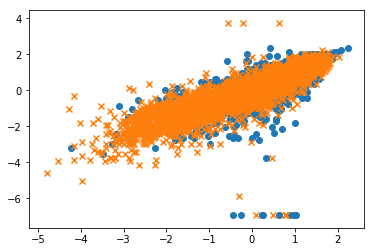

In [193]:
ut.plot2DSet(labSet)

In [198]:
N = 100 # Nombre de tours d'apprentissage

In [199]:
classif = cl.ClassifierGradientSto(len(columnsX), 1e-3)

accuracyLearn = np.zeros(N)
accuracyTest = np.zeros(N)

for i in range(N):
    accuracyLearn[i] = classif.accuracy(labSetLearn)
    accuracyTest[i] = classif.accuracy(labSetTest)
    classif.train(labSetLearn)

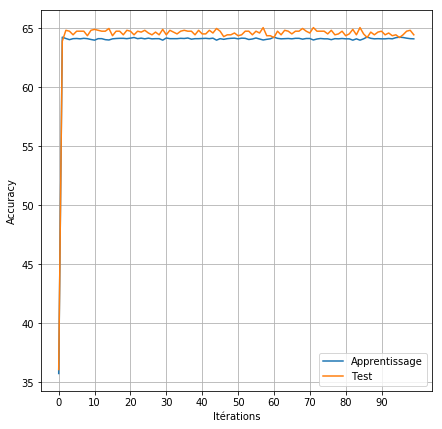

In [207]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.grid(True)
ax.set_axisbelow(True)
ax.plot(accuracyLearn, label="Apprentissage")
ax.plot(accuracyTest, label="Test")
ax.legend(loc="lower right")
ax.set_xlabel("Itérations")
ax.set_xticks(range(0, N, int(N/10)))
ax.set_ylabel("Accuracy")
plt.show()

In [206]:
print(classif.accuracy(labSetLearn), classif.accuracy(labSetTest))

64.11838967597139 64.82758620689654


On a ainsi une _accuracy_ d’environ 60 % pour les données d’apprentissage et de test. Cela est un bon résultat, notamment car notre classifieur se base sur très peu d’informations &mdash; les deux notes &mdash; et il est bien supérieur à ce qu’on obtiendrait, par exemple, avec un classifieur aléatoire ou par classe majoritaire.

En vue de ce résultat positif, on teste d’autres classifieurs vus en cours sur ce même problème de classification.

Perceptron par gradient stochastique kernelisé :

In [208]:
kernel = ut.KernelPoly()
classif = cl.ClassifierGradientStoKernel(kernel.transform(labSet.x[0]).size, 1e-3, kernel)

accuracyLearn = np.zeros(N)
accuracyTest = np.zeros(N)

for i in range(N):
    accuracyLearn[i] = classif.accuracy(labSetLearn)
    accuracyTest[i] = classif.accuracy(labSetTest)
    classif.train(labSetLearn)

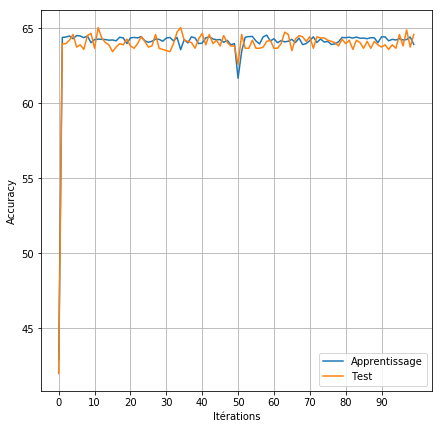

In [209]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.grid(True)
ax.set_axisbelow(True)
ax.plot(accuracyLearn, label="Apprentissage")
ax.plot(accuracyTest, label="Test")
ax.legend(loc="lower right")
ax.set_xlabel("Itérations")
ax.set_xticks(range(0, N, int(N/10)))
ax.set_ylabel("Accuracy")
plt.show()

In [210]:
print(classif.accuracy(labSetLearn), classif.accuracy(labSetTest))

64.09033525038575 63.754789272030656


Classifieur par KNN :

In [213]:
classif = cl.ClassifierKNN(len(columnsX), 5)
classif.train(labSetLearn)

In [214]:
# ATTENTION, l'exécution de cette cellule prend beaucoup de temps !
print(classif.accuracy(labSetLearn), classif.accuracy(labSetTest))

72.87137045868985 60.15325670498084


Arbre de décision simple :

In [232]:
classif = cl.ArbreDecision(0.01)
classif.train(labSetLearn)

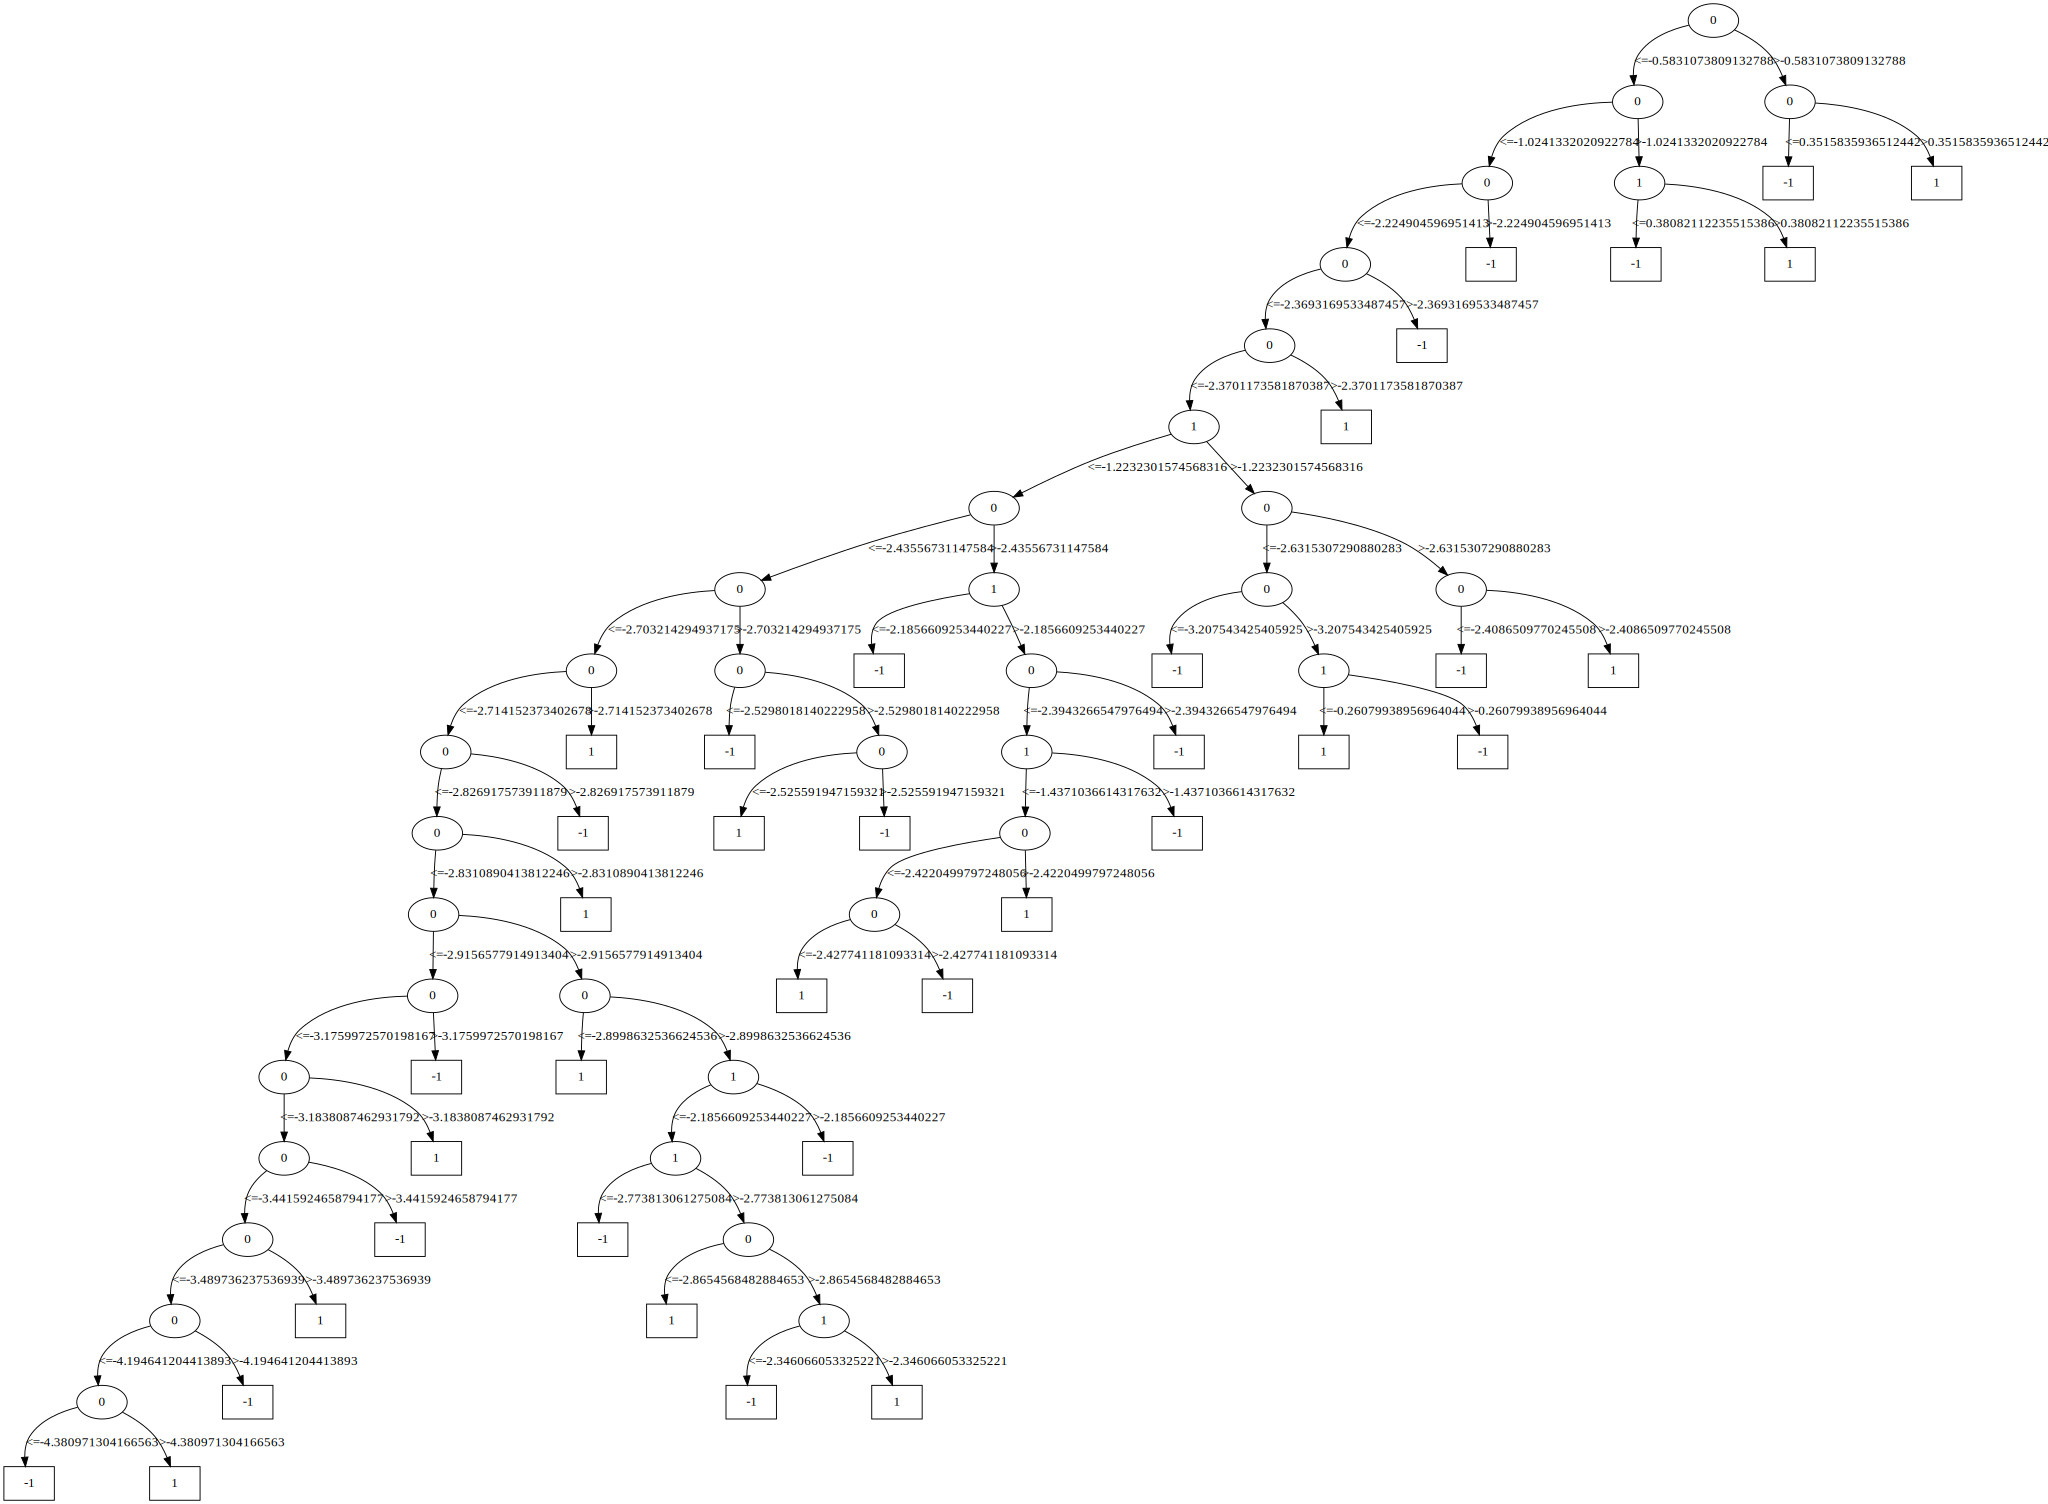

In [233]:
classif.plot()

In [234]:
print(classif.accuracy(labSetLearn), classif.accuracy(labSetTest))

63.78173656894375 64.75095785440614


Bagging d'arbre de décision et évaluation par la méthode OOB :

In [235]:
classif = cl.ClassifierBaggingTreeOOB(20, 0.3, 0.01, True)
classif.train(labSetLearn)

In [236]:
print(classif.accuracy(labSetLearn), classif.accuracy(labSetTest), classif.accuracyOOB(labSetLearn))

65.08626735867583 63.984674329501914 65.0104469478488


On remarque ainsi que ces méthodes ont toutes des taux d’_accuracy_ entre 60 % et 65 %. Cette similarité de résultats suggère que le facteur limitant n’est pas les méthodes utilisées mais plutôt notre choix d’utiliser uniquement les notes données par les utilisateurs, qui ne contiennent pas assez d’information pour retrouver avec une meilleure certitude le genre d’un film.

On peut se demander si, avec plus d’informations, comme par exemple le nombre d’acteurs participant du film, le nombre de membres de l’équipe de production ou la quantité d’utilisateurs de MovieLens et TMDb ayant noté le film, on peut améliorer le résultat. Ce test est fait dans les cellules suivantes pour les comédies, qui représentent environ 37 % de la base de données. On utilise un perceptron avec gradient stochastique.

In [250]:
moviesUsed = movies[movies["nbRatingML"] >= 100]

columnsX = ["nbActors", "nbCrew", "ratingML", "nbRatingML", "ratingTmdb", "nbRatingTmdb"]
columnY = ["comedy"]

labSet = ls.LabeledSet(len(columnsX))
labSet.x = (moviesUsed[columnsX].values - moviesUsed[columnsX].mean().values)/moviesUsed[columnsX].std().values
labSet.y = moviesUsed[columnY].values.reshape(-1, 1)
labSet.nb_examples = labSet.y.shape[0]

labSetLearn, labSetTest = ut.split(labSet, p_train = 0.85)

print("Quantité de données dans le LabeledSet : {:d}".format(labSet.nb_examples))

Quantité de données dans le LabeledSet : 8434


In [251]:
print("Proportion de films du genre " + columnY[0] + " dans la base de données : {:.2f}%"\
      .format(100*(labSet.y==1).sum()/labSet.nb_examples))

Proportion de films du genre comedy dans la base de données : 36.66%


In [252]:
N = 100 # Nombre de tours d'apprentissage

In [253]:
classif = cl.ClassifierGradientSto(len(columnsX), 1e-3)

accuracyLearn = np.zeros(N)
accuracyTest = np.zeros(N)

for i in range(N):
    accuracyLearn[i] = classif.accuracy(labSetLearn)
    accuracyTest[i] = classif.accuracy(labSetTest)
    classif.train(labSetLearn)

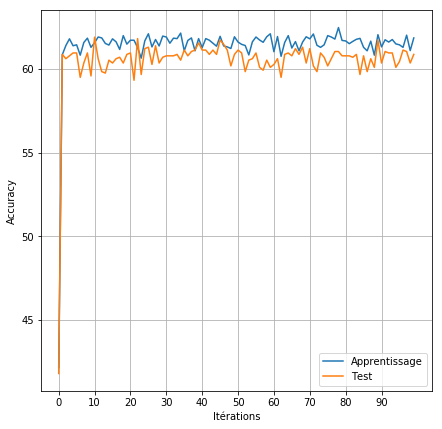

In [254]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.grid(True)
ax.set_axisbelow(True)
ax.plot(accuracyLearn, label="Apprentissage")
ax.plot(accuracyTest, label="Test")
ax.legend(loc="lower right")
ax.set_xlabel("Itérations")
ax.set_xticks(range(0, N, int(N/10)))
ax.set_ylabel("Accuracy")
plt.show()

In [255]:
print(classif.accuracy(labSetLearn), classif.accuracy(labSetTest))

61.697153073855034 59.41530524505589


On remarque que les valeurs d’_accuracy_ obtenues sont assez similaires à celles du cas précédent. Cependant, en comparant ce classifieur avec un classifieur par classe majoritaire, on remarque qu’il n’est pas aussi bon que le précédent. En effet, dans la classification de films de drame, comme on a environ 49 % de films de drame dans le dataset, une classification par classe majoritaire classifie tout film comme non-drame, donnant une réponse correcte dans environ 51 % des cas. Dans cette classification de comédies, comme environ 37 % des films dans la base de données sont des comédies, la classification par classe majoritaire donne une réponse correcte dans 63 % des cas. Ce classifieur n’est donc pas mieux qu’une classification par classe majoritaire.

Pour mieux comprendre l’influence des paramètres utilisés sur la classification des films, on peut calculer la corrélation entre ces paramètres et les genres de films, ce qui est fait dans la cellule suivante. On remarque que cette corrélation est en général très petite, ce qui suggère que, finalement, les paramètres choisis ont peu d’influence sur la classification en genre d’un film. Cependant, cela n’est pas le cas pour toutes les genres de film : on remarque, par exemple, que les notes d’utilisateur sont en général plus grandes pour les drames et plus petites pour les films d’horreur. Cela explique le succès de notre classificateur de drames en fonction de leurs notes et sa performance supérieure à la classification par classe majoritaire.

In [257]:
mc = movies[["nbActors", "nbCrew", "ratingML", "nbRatingML", "ratingTmdb", "nbRatingTmdb"] + [g.lower() for g in genres]].corr()
mc = mc[["nbActors", "nbCrew", "ratingML", "nbRatingML", "ratingTmdb", "nbRatingTmdb"]].loc[[g.lower() for g in genres]]
mc.apply(lambda x: np.around(x, 2))

,nbActors,nbCrew,ratingML,nbRatingML,ratingTmdb,nbRatingTmdb
action,0.12,0.18,-0.09,0.11,-0.06,0.17
adventure,0.08,0.14,-0.03,0.12,0.00,0.18
animation,-0.02,0.10,0.02,0.03,0.06,0.09
children,0.01,0.07,-0.06,0.05,-0.01,0.09
comedy,0.06,-0.03,-0.05,0.03,-0.06,0.00
crime,0.07,0.04,0.02,0.04,0.04,0.04
documentary,-0.15,-0.09,0.13,-0.05,0.07,-0.07
drama,0.01,-0.04,0.21,-0.03,0.17,-0.05
fantasy,0.03,0.07,-0.01,0.06,0.00,0.11
film-noir,0.02,-0.01,0.06,-0.00,0.04,-0.02


In [ ]:
# TODO : classificar as animações a partir das outras coisas (ex: detalhes da crew).
# TODO : regressão de notas (modificar perceptron), usando os features que o Ricardo sugeriu.
# TODO : catégorisation non-supervisée.